## 8번. 이미지 더 추가한 train data로 실행

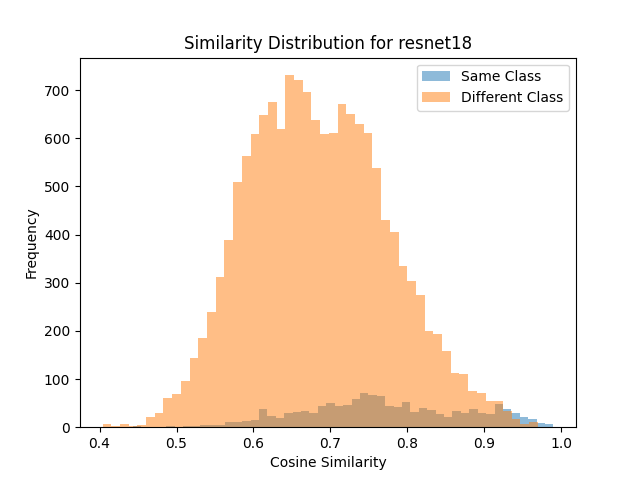 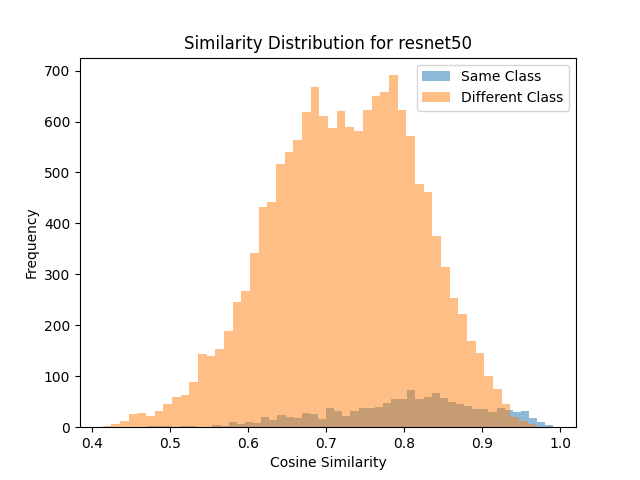 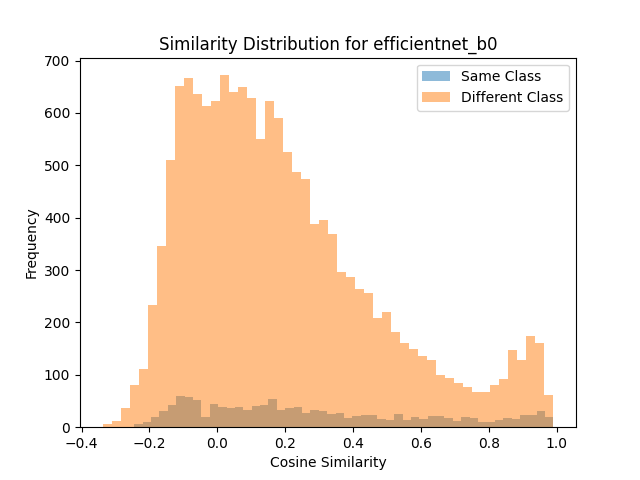 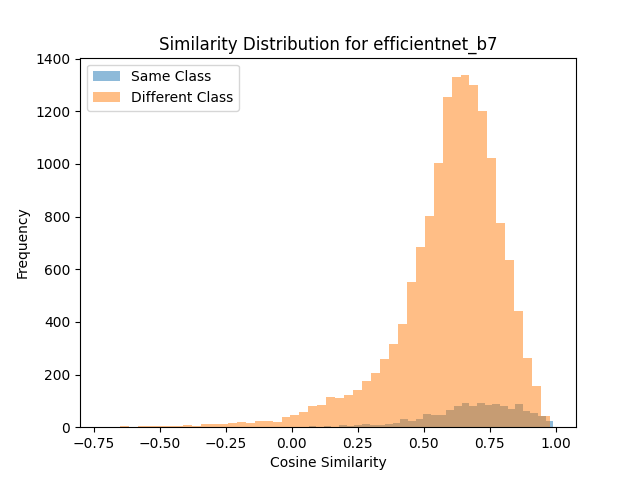

Model: resnet18
Processing Time per Image: 0.05047349091414567

Model: resnet50
Processing Time per Image: 0.09199442313267635

Model: efficientnet_b0
Processing Time per Image: 0.04574091748876886

Model: efficientnet_b7
Processing Time per Image: 0.21225685208708375

## 8번 normalization + X축 통일

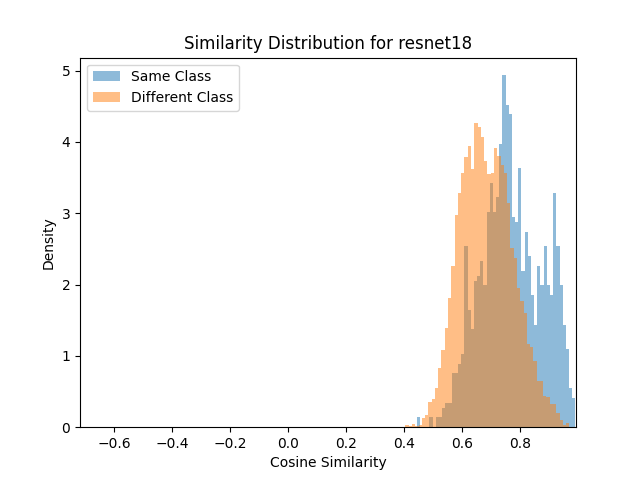 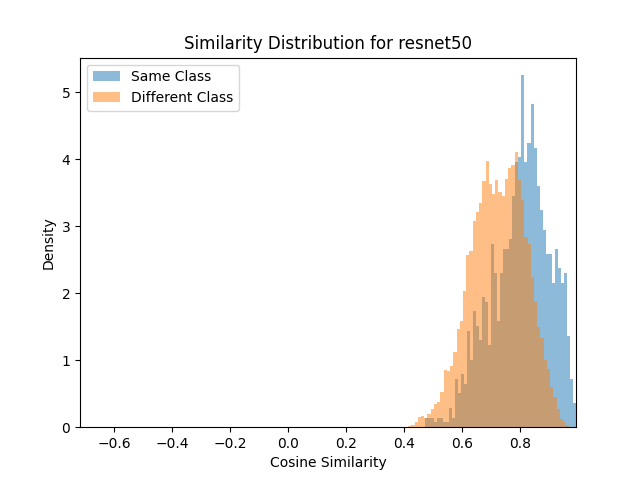 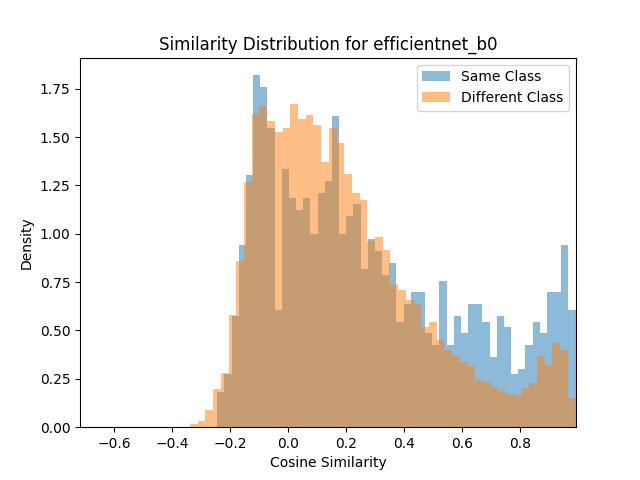 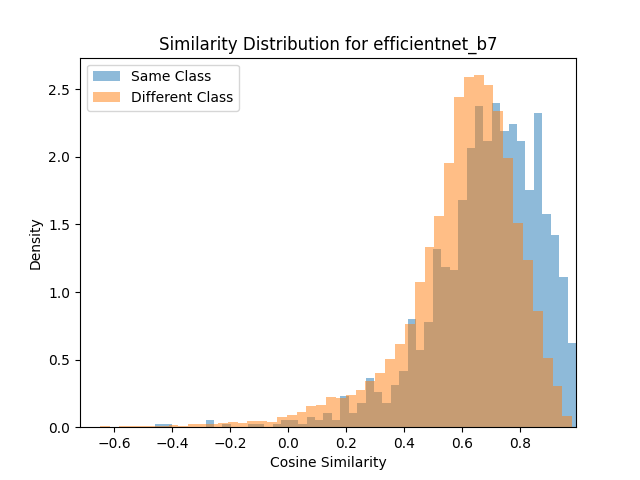

Model: resnet18
Processing Time per Image: 0.04271806596399664

Model: resnet50
Processing Time per Image: 0.10787334677937267

Model: efficientnet_b0
Processing Time per Image: 0.04397951639615572

Model: efficientnet_b7
Processing Time per Image: 0.20475116404858265

In [ ]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import time
import certifi
import os
import ssl
import matplotlib.pyplot as plt

# SSL 인증서 설정
os.environ['SSL_CERT_FILE'] = certifi.where()
ssl._create_default_https_context = ssl._create_unverified_context

class Img2Vec():
    RESNET_OUTPUT_SIZES = {
        'resnet18': 512,
        'resnet34': 512,
        'resnet50': 2048,
        'resnet101': 2048,
        'resnet152': 2048
    }

    EFFICIENTNET_OUTPUT_SIZES = {
        'efficientnet_b0': 1280,
        'efficientnet_b1': 1280,
        'efficientnet_b2': 1408,
        'efficientnet_b3': 1536,
        'efficientnet_b4': 1792,
        'efficientnet_b5': 2048,
        'efficientnet_b6': 2304,
        'efficientnet_b7': 2560
    }

    def __init__(self, cuda=False, model='resnet18', layer='default', layer_output_size=512, gpu=0):
        self.device = torch.device(f"cuda:{gpu}" if cuda else "cpu")
        self.layer_output_size = layer_output_size
        self.model_name = model

        self.model, self.extraction_layer = self._get_model_and_layer(model, layer)

        self.model = self.model.to(self.device)

        self.model.eval()

        self.scaler = transforms.Resize((224, 224))
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])
        self.to_tensor = transforms.ToTensor()

    def get_vec(self, img, tensor=False):
        if type(img) == list:
            a = [self.normalize(self.to_tensor(self.scaler(im))) for im in img]
            images = torch.stack(a).to(self.device)
            if self.model_name in ['alexnet', 'vgg']:
                my_embedding = torch.zeros(len(img), self.layer_output_size)
            elif self.model_name == 'densenet' or 'efficientnet' in self.model_name:
                my_embedding = torch.zeros(len(img), self.layer_output_size, 7, 7)
            else:
                my_embedding = torch.zeros(len(img), self.layer_output_size, 1, 1)

            def copy_data(m, i, o):
                my_embedding.copy_(o.data)

            h = self.extraction_layer.register_forward_hook(copy_data)
            with torch.no_grad():
                h_x = self.model(images)
            h.remove()

            if tensor:
                return my_embedding
            else:
                if self.model_name in ['alexnet', 'vgg']:
                    return my_embedding.numpy()[:, :]
                elif self.model_name == 'densenet' or 'efficientnet' in self.model_name:
                    return torch.mean(my_embedding, (2, 3), True).numpy()[:, :, 0, 0]
                else:
                    return my_embedding.numpy()[:, :, 0, 0]
        else:
            image = self.normalize(self.to_tensor(self.scaler(img))).unsqueeze(0).to(self.device)

            if self.model_name in ['alexnet', 'vgg']:
                my_embedding = torch.zeros(1, self.layer_output_size)
            elif self.model_name == 'densenet' or 'efficientnet' in self.model_name:
                my_embedding = torch.zeros(1, self.layer_output_size, 7, 7)
            else:
                my_embedding = torch.zeros(1, self.layer_output_size, 1, 1)

            def copy_data(m, i, o):
                my_embedding.copy_(o.data)

            h = self.extraction_layer.register_forward_hook(copy_data)
            with torch.no_grad():
                h_x = self.model(image)
            h.remove()

            if tensor:
                return my_embedding
            else:
                if self.model_name in ['alexnet', 'vgg']:
                    return my_embedding.numpy()[0, :]
                elif self.model_name == 'densenet':
                    return torch.mean(my_embedding, (2, 3), True).numpy()[0, :, 0, 0]
                else:
                    return my_embedding.numpy()[0, :, 0, 0]

    def _get_model_and_layer(self, model_name, layer):
        if model_name.startswith('resnet') and not model_name.startswith('resnet-'):
            model = getattr(models, model_name)(pretrained=True)
            if layer == 'default':
                layer = model._modules.get('avgpool')
                self.layer_output_size = self.RESNET_OUTPUT_SIZES[model_name]
            else:
                layer = model._modules.get(layer)
            return model, layer
        elif model_name == 'resnet-18':
            model = models.resnet18(pretrained=True)
            if layer == 'default':
                layer = model._modules.get('avgpool')
                self.layer_output_size = 512
            else:
                layer = model._modules.get(layer)

            return model, layer

        elif model_name == 'alexnet':
            model = models.alexnet(pretrained=True)
            if layer == 'default':
                layer = model.classifier[-2]
                self.layer_output_size = 4096
            else:
                layer = model.classifier[-layer]

            return model, layer

        elif model_name == 'vgg':
            model = models.vgg11_bn(pretrained=True)
            if layer == 'default':
                layer = model.classifier[-2]
                self.layer_output_size = model.classifier[-1].in_features
            else:
                layer = model.classifier[-layer]

            return model, layer

        elif model_name == 'densenet':
            model = models.densenet121(pretrained=True)
            if layer == 'default':
                layer = model.features[-1]
                self.layer_output_size = model.classifier.in_features
            else:
                raise KeyError('Un support %s for layer parameters' % model_name)

            return model, layer

        elif "efficientnet" in model_name:
            if model_name == "efficientnet_b0":
                model = models.efficientnet_b0(pretrained=True)
            elif model_name == "efficientnet_b1":
                model = models.efficientnet_b1(pretrained=True)
            elif model_name == "efficientnet_b2":
                model = models.efficientnet_b2(pretrained=True)
            elif model_name == "efficientnet_b3":
                model = models.efficientnet_b3(pretrained=True)
            elif model_name == "efficientnet_b4":
                model = models.efficientnet_b4(pretrained=True)
            elif model_name == "efficientnet_b5":
                model = models.efficientnet_b5(pretrained=True)
            elif model_name == "efficientnet_b6":
                model = models.efficientnet_b6(pretrained=True)
            elif model_name == "efficientnet_b7":
                model = models.efficientnet_b7(pretrained=True)
            else:
                raise KeyError('Un support %s.' % model_name)

            if layer == 'default':
                layer = model.features
                self.layer_output_size = self.EFFICIENTNET_OUTPUT_SIZES[model_name]
            else:
                raise KeyError('Un support %s for layer parameters' % model_name)

            return model, layer

        else:
            raise KeyError('Model %s was not found' % model_name)
        
def calculate_similarity(embeddings):
    return cosine_similarity(embeddings)

def load_images_from_folder(folder):
    images = []
    labels = []
    valid_image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']
    for class_folder_name in os.listdir(folder):
        class_folder_path = os.path.join(folder, class_folder_name)
        if not os.path.isdir(class_folder_path):
            continue
        for filename in os.listdir(class_folder_path):
            img_path = os.path.join(class_folder_path, filename)
            if os.path.splitext(filename)[1].lower() in valid_image_extensions:
                img = Image.open(img_path).convert('RGB')
                images.append(img)
                labels.append(class_folder_name)
    return images, labels

def pairwise_similarity_distribution(embeddings, labels):
    same_class_sims = []
    diff_class_sims = []

    num_embeddings = len(embeddings)
    for i in range(num_embeddings):
        for j in range(i + 1, num_embeddings):
            sim = cosine_similarity([embeddings[i]], [embeddings[j]])[0][0]
            if labels[i] == labels[j]:
                same_class_sims.append(sim)
            else:
                diff_class_sims.append(sim)
    
    return same_class_sims, diff_class_sims

def plot_similarity_distribution(same_class_sims, diff_class_sims, model_name, xlim):
    plt.hist(same_class_sims, bins=50, alpha=0.5, label='Same Class', density=True)
    plt.hist(diff_class_sims, bins=50, alpha=0.5, label='Different Class', density=True)
    plt.xlabel('Cosine Similarity')
    plt.ylabel('Density')
    plt.title(f'Similarity Distribution for {model_name}')
    plt.legend()
    plt.xlim(xlim)
    plt.show()

def classify_images(model_names, folder_path, cuda=False):
    images, labels = load_images_from_folder(folder_path)

    results = {}
    all_similarities = []
    for model_name in model_names:
        print(f"Evaluating model {model_name}")
        img2vec = Img2Vec(cuda=cuda, model=model_name)

        start_time = time.time()
        embeddings = [img2vec.get_vec(img) for img in images]
        embeddings = np.array(embeddings)
        processing_time = (time.time() - start_time) / len(images)

        same_class_sims, diff_class_sims = pairwise_similarity_distribution(embeddings, labels)

        all_similarities.extend(same_class_sims + diff_class_sims)

        results[model_name] = {
            'same_class_sims': same_class_sims,
            'diff_class_sims': diff_class_sims,
            'processing_time': processing_time
        }

    global_xlim = (min(all_similarities), max(all_similarities))
    for model_name, result in results.items():
        plot_similarity_distribution(result['same_class_sims'], result['diff_class_sims'], model_name, global_xlim)

    return results

if __name__ == "__main__":
    folder_path = './data-gatter/train_L'
    model_names = ['resnet18', 'resnet50', 'efficientnet_b0', 'efficientnet_b7']
    cuda = torch.cuda.is_available()

    results = classify_images(model_names, folder_path, cuda)
    for model_name, result in results.items():
        print(f"\nModel: {model_name}")
        print(f"Processing Time per Image: {result['processing_time']}")


## New Model_OmniVec & CoCa

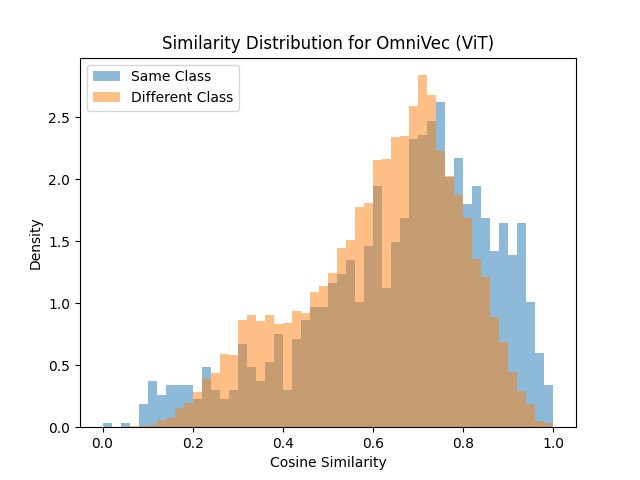 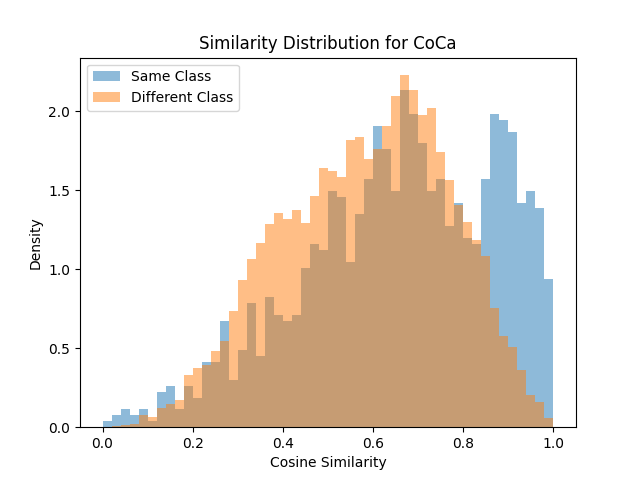

Model: OmniVec (ViT)
Processing Time per Image: 0.2822321483067104

Model: CoCa
Processing Time per Image: 0.13012898492289113

OmniVec (ViT) 
- same class
  - 유사도가 주로 0.7 ~ 1.0에서 분포
  - 같은 class의 이미지들이 높은 유사도 가짐!
- different class
  - 유사도가 0.3 ~ 0.8 에서 분포
  
- 어느 정도 클래스 간 겹치는 부분 있지만, 전반적으로 same class의 유사도가 더 높음. 

CoCa
- same class
  - 유사도가 주로 0.6 ~ 1.0에서 분포
- different class
  - 유사도가 0.3 ~ 0.8 에서 분포
  
- 클래스 간 겹치는 부분 OmniVec에 비해 더 많음

In [ ]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import confusion_matrix
import time
import os
import ssl
import matplotlib.pyplot as plt
import seaborn as sns
from open_clip import create_model_and_transforms, tokenize  # OpenCLIP 불러오기

# SSL 인증서 설정
import certifi
os.environ['SSL_CERT_FILE'] = certifi.where()
ssl._create_default_https_context = ssl._create_unverified_context

class CoCaImg2Vec():
    def __init__(self, model_name, pretrained, cuda=False):
        self.model, _, self.transform = create_model_and_transforms(model_name, pretrained=pretrained)
        self.device = torch.device("cuda" if cuda else "cpu")
        self.model = self.model.to(self.device)
        self.model.eval()

    def get_vec(self, img):
        image = self.transform(img).unsqueeze(0).to(self.device)
        with torch.no_grad():
            embedding = self.model.encode_image(image).cpu().numpy().flatten()
        return embedding

class Img2Vec():
    def __init__(self, model_name, cuda=False):
        self.device = torch.device("cuda" if cuda else "cpu")
        self.model = getattr(models, model_name)(pretrained=True).to(self.device)
        self.model.eval()
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def get_vec(self, img):
        image = self.transform(img).unsqueeze(0).to(self.device)
        with torch.no_grad():
            embedding = self.model(image)
        return embedding.cpu().numpy().flatten()

def load_images_from_folder(folder):
    images = []
    labels = []
    valid_image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']
    for class_folder_name in os.listdir(folder):
        class_folder_path = os.path.join(folder, class_folder_name)
        if not os.path.isdir(class_folder_path):
            continue
        for filename in os.listdir(class_folder_path):
            img_path = os.path.join(class_folder_path, filename)
            if os.path.splitext(filename)[1].lower() in valid_image_extensions:
                img = Image.open(img_path).convert('RGB')
                images.append(img)
                labels.append(class_folder_name)
    return images, labels

def pairwise_similarity_distribution(embeddings, labels):
    same_class_sims = []
    diff_class_sims = []

    num_embeddings = len(embeddings)
    for i in range(num_embeddings):
        for j in range(i + 1, num_embeddings):
            sim = cosine_similarity([embeddings[i]], [embeddings[j]])[0][0]
            if labels[i] == labels[j]:
                same_class_sims.append(sim)
            else:
                diff_class_sims.append(sim)
    
    return same_class_sims, diff_class_sims

def normalize_similarity_scores(scores):
    min_score = min(scores)
    max_score = max(scores)
    normalized_scores = [(score - min_score) / (max_score - min_score) for score in scores]
    return normalized_scores

def plot_similarity_distribution(same_class_sims, diff_class_sims, model_name, x_range):
    plt.hist(same_class_sims, bins=50, alpha=0.5, label='Same Class', density=True, range=x_range)
    plt.hist(diff_class_sims, bins=50, alpha=0.5, label='Different Class', density=True, range=x_range)
    plt.xlabel('Cosine Similarity')
    plt.ylabel('Density')
    plt.title(f'Similarity Distribution for {model_name}')
    plt.legend()
    plt.show()

def plot_confusion_matrix(true_labels, pred_labels, model_name, class_names):
    cm = confusion_matrix(true_labels, pred_labels, labels=class_names)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

def classify_images(model_dict, folder_path, cuda=False):
    images, labels = load_images_from_folder(folder_path)
    results = {}

    all_similarities = []
    for model_name, model in model_dict.items():
        print(f"Evaluating model {model_name}")
        if model_name == 'CoCa':
            img2vec = CoCaImg2Vec(model, pretrained='mscoco_finetuned_laion2b_s13b_b90k', cuda=cuda)
        else:
            img2vec = Img2Vec(model, cuda=cuda)

        start_time = time.time()
        embeddings = [img2vec.get_vec(img) for img in images]
        embeddings = np.array(embeddings)
        processing_time = (time.time() - start_time) / len(images)

        same_class_sims, diff_class_sims = pairwise_similarity_distribution(embeddings, labels)
        same_class_sims = normalize_similarity_scores(same_class_sims)
        diff_class_sims = normalize_similarity_scores(diff_class_sims)

        all_similarities.extend(same_class_sims + diff_class_sims)

        # Confusion Matrix 계산을 위해 예측 레이블 생성
        predicted_labels = []
        for emb in embeddings:
            sims = cosine_similarity([emb], embeddings)[0]
            sims = [(s, labels[idx]) for idx, s in enumerate(sims)]
            sims = sorted(sims, key=lambda x: x[0], reverse=True)
            top_label = sims[1][1]  # 가장 유사한 (자기 자신을 제외한) 이미지의 레이블 선택
            predicted_labels.append(top_label)
        
        class_names = list(set(labels))
        plot_confusion_matrix(labels, predicted_labels, model_name, class_names)

        results[model_name] = {
            'same_class_sims': same_class_sims,
            'diff_class_sims': diff_class_sims,
            'processing_time': processing_time
        }

    global_xlim = (0, 1)
    for model_name, result in results.items():
        plot_similarity_distribution(result['same_class_sims'], result['diff_class_sims'], model_name, global_xlim)

    return results

if __name__ == "__main__":
    folder_path = './data-gatter/train_L'
    from torchvision import models as torchvision_models

    model_dict = {
        'OmniVec (ViT)': 'vit_b_16',
        'CoCa': 'coca_ViT-B-32'
    }

    cuda = torch.cuda.is_available()

    results = classify_images(model_dict, folder_path, cuda)
    for model_name, result in results.items():
        print(f"\nModel: {model_name}")
        print(f"Processing Time per Image: {result['processing_time']}")


## New Model_ConvNeXt & swimV2 & EfficientNetV2 & (OmniVec & CoCa 같이 비교)

### 1. OmniVec
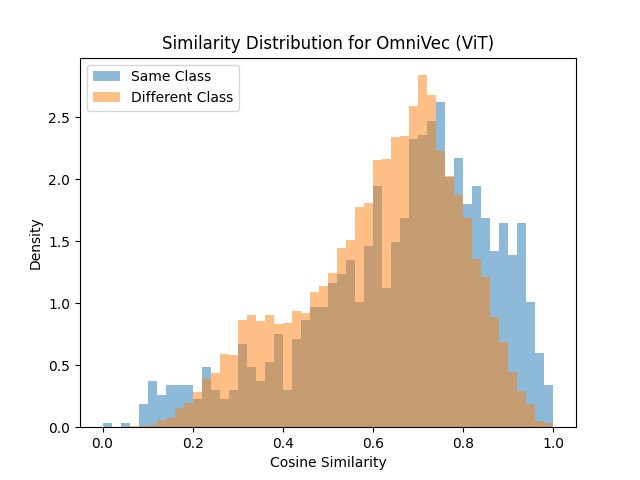 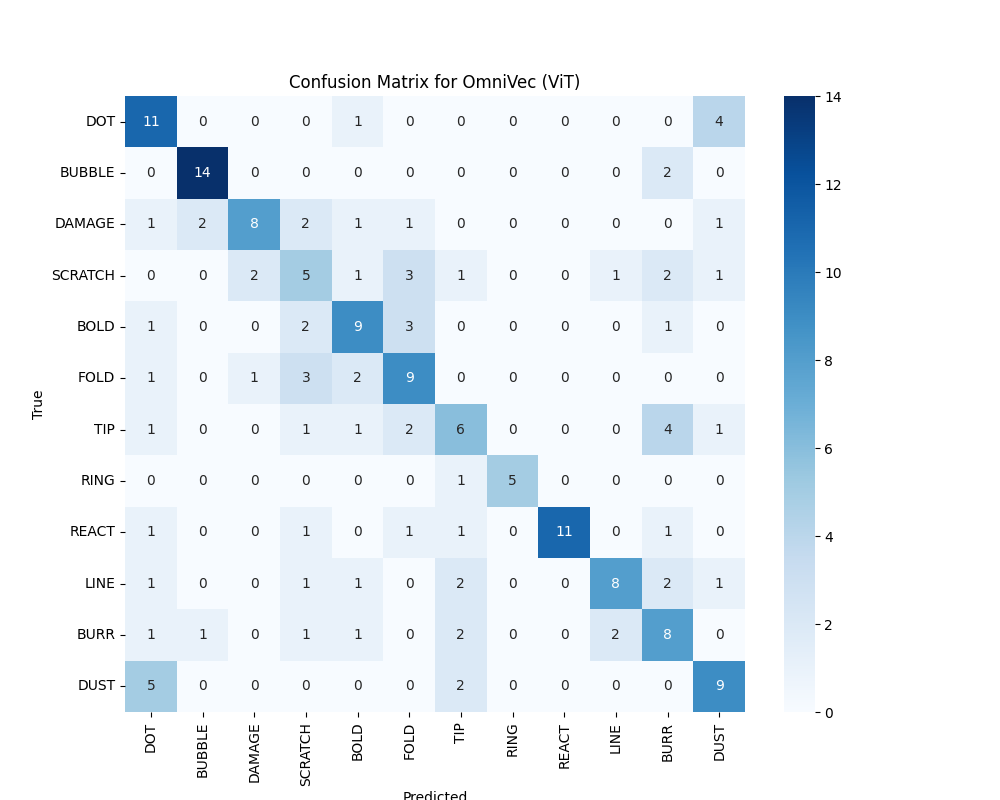

- 전반적으로 대부분의 클래스를 정확하게 분류하는 능력을 보여줍니다.
- 몇 가지 눈에 띄는 오분류가 있습니다:
  - "DOT" 클래스가 4번 "DUST"로 오분류됨.
  - "SCRATCH" 클래스는 "DAMAGE"와 "TIP"을 포함한 다양한 클래스와 혼동됨.

- 동일 클래스 간 유사도가 주로 0.7 ~ 1.0에서 분포, 다른 클래스 간 유사도가 0.3 ~ 0.8 에서 분포
- 어느 정도 클래스 간 겹치는 부분 있지만, 전반적으로 same class의 유사도가 더 높음. 

### 2. CoCa
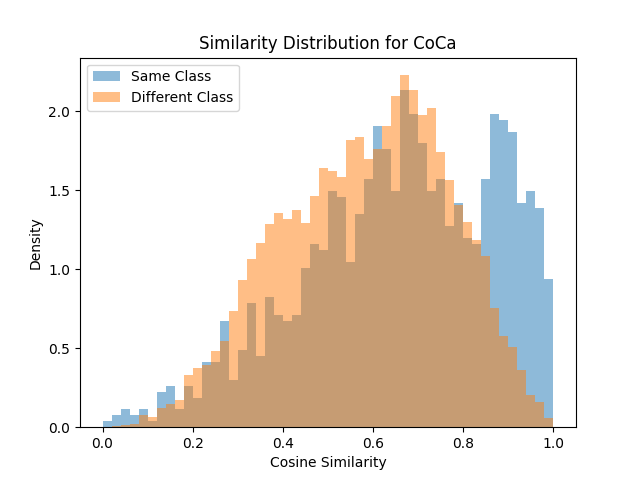 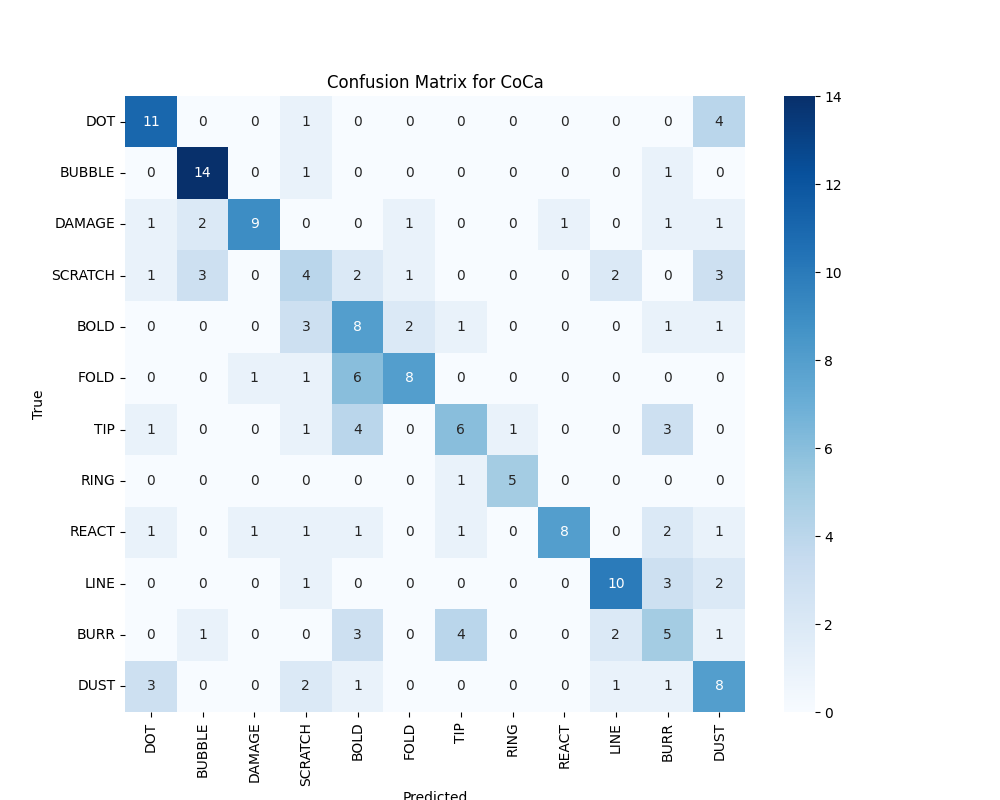

- OmniVec와 유사한 성능 but 약간의 차이
- 몇 가지 눈에 띄는 오분류가 있습니다:
  - "DOT" 클래스가 4번 "DUST"로 오분류됨.
  - "SCRATCH" 클래스는 "DAMAGE"와 "TIP"을 포함한 다양한 클래스와 혼동됨.

- 동일 클래스 간 유사도가 주로 0.6 ~ 1.0에서 분포, 다른 클래스 간 유사도가 0.2 ~ 0.8 에서 분포
- 어느 정도 클래스 간 겹치는 부분 있지만, 전반적으로 same class의 유사도가 더 높음. 

### 3. Swin Transformer V2
![swim v2.png](<attachment:swim v2.png>) 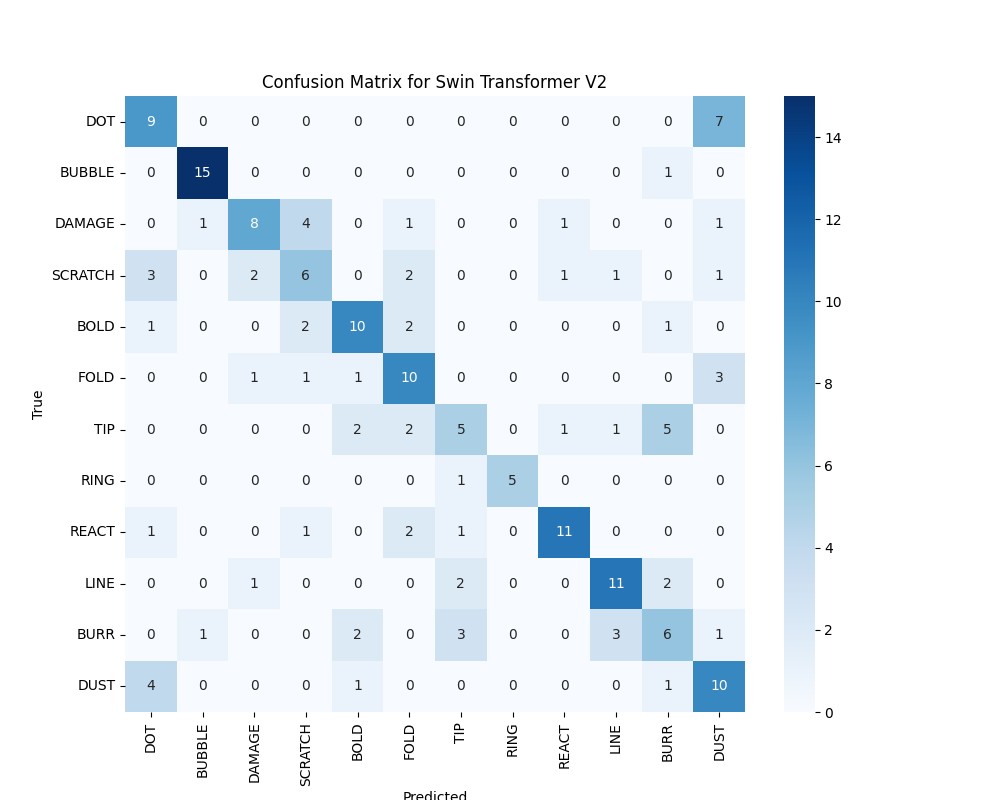

- 몇 가지 영역에서 개선된 성능
- "BUBBLE" 클래스는 15개의 인스턴스에서 완벽하게 분류, 오분류 x.
- 오분류는 여러 클래스에 분산 but, 특정 클래스에서 특히 높은 오분류율을 보이지 x.

- 동일 클래스 간 유사도가 주로 0.6 ~ 1.0에서 분포, 다른 클래스 간 유사도가 0.2 ~ 0.8 에서 분포
- 다른 모델들에 비해 동일 클래스 유사도가 더 높은 빈도로 나타남. 
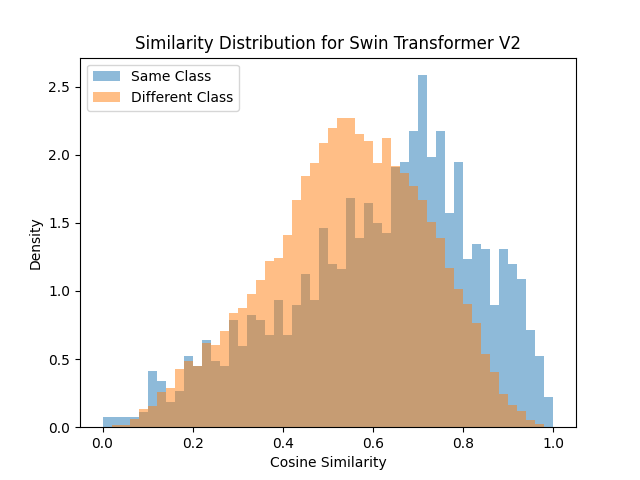

### 4. ConvNeXt
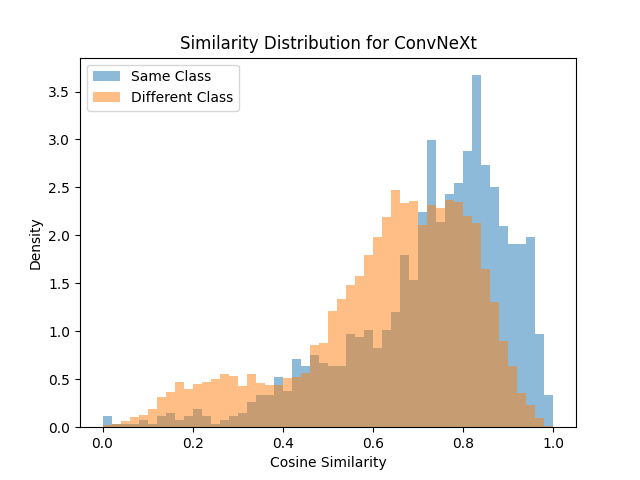 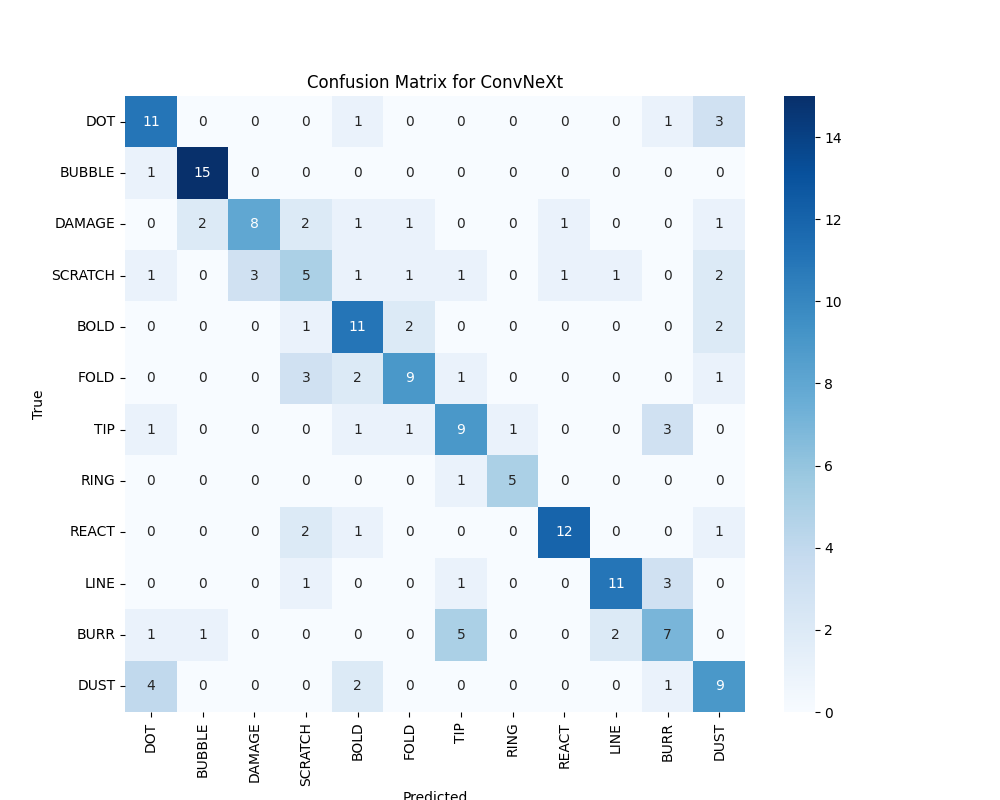

- Swin Transformer V2와 유사한 성능
- 대부분의 클래스에서 안정적인 분류 성능
- 특정 클래스에서 오분류가 발생. but 전반적으로 균형 잡힌 성능을 보입니다.

- 동일 클래스 간 유사도가 주로 0.6 ~ 1.0에서 분포, 다른 클래스 간 유사도가 0.2 ~ 0.8 에서 분포
- 동일 클래스 유사도가 상대적으로 더 높은 빈도로 나타남. 

### 5. EfficientNetV2
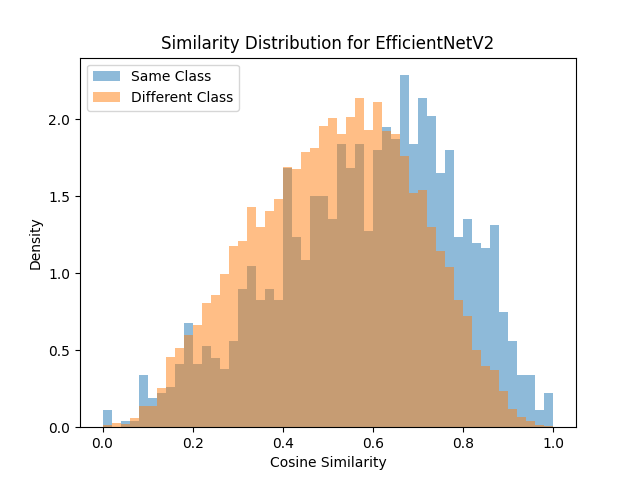 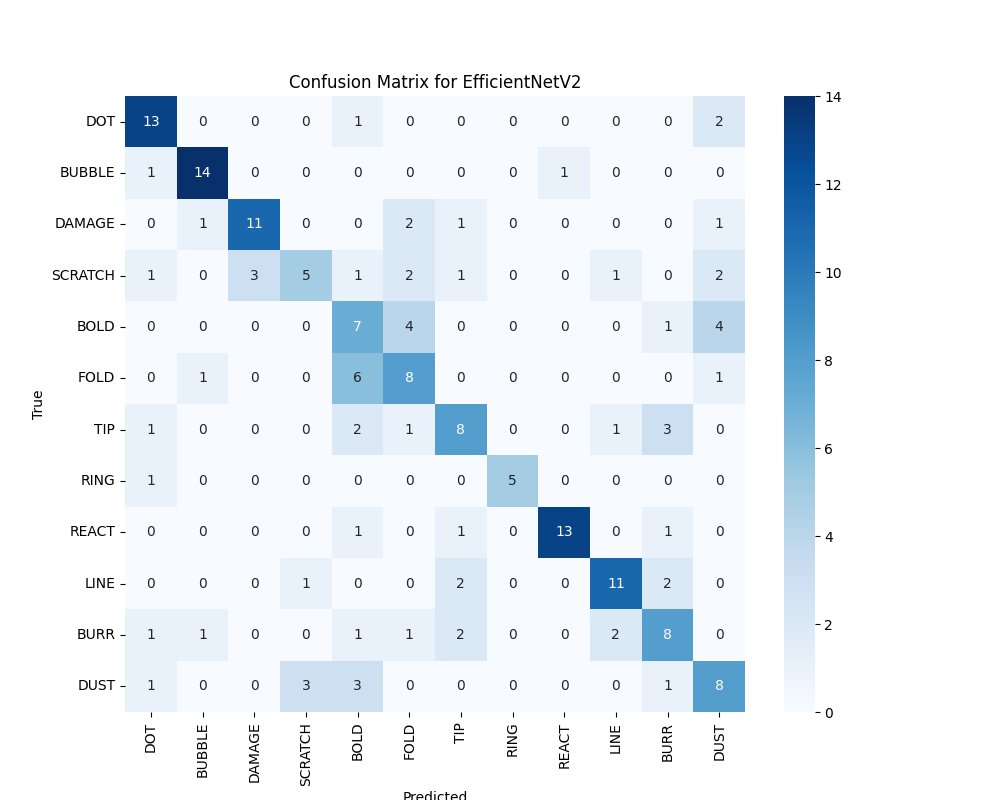

- 전반적으로 높은 정확도,  다양한 클래스에서 안정적인 성능
- 몇 가지 눈에 띄는 오분류가 존재. but 대부분의 클래스에서 좋은 성능

- 동일 클래스 간 유사도가 주로 0.4 ~ 1.0에서 분포, 다른 클래스 간 유사도가 0.2 ~ 0.8 에서 분포
- 두 분포가 약간 겹치지만, 동일 클래스 유사도가 더 높은 경향
 

Model: OmniVec (ViT)
Processing Time per Image: 0.25837691799624934

Model: CoCa
Processing Time per Image: 0.12542060967330093

Model: Swin Transformer V2
Processing Time per Image: 0.4485026322878324

Model: ConvNeXt
Processing Time per Image: 0.33796413521190266

Model: EfficientNetV2
Processing Time per Image: 0.13248429193601505

### **결론**
### - 모든 모델이 전반적으로 높은 성능! BUT 일부 클래스에서는 오분류 발생
### - 동일 클래스 간 유사도가 다른 클래스보다 더 높음
### - Swin Transformer V2와 ConvNeXt가 특히 높은 성능, 특정 클래스에서의 오분류 적음

In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import confusion_matrix
import time
import os
import ssl
import matplotlib.pyplot as plt
import seaborn as sns
from open_clip import create_model_and_transforms, tokenize
import torchvision.models as models

# SSL 인증서 설정
import certifi
os.environ['SSL_CERT_FILE'] = certifi.where()
ssl._create_default_https_context = ssl._create_unverified_context

class CoCaImg2Vec():
    def __init__(self, model_name, pretrained, cuda=False):
        self.model, _, self.transform = create_model_and_transforms(model_name, pretrained=pretrained)
        self.device = torch.device("cuda" if cuda else "cpu")
        self.model = self.model.to(self.device)
        self.model.eval()

    def get_vec(self, img):
        image = self.transform(img).unsqueeze(0).to(self.device)
        with torch.no_grad():
            embedding = self.model.encode_image(image).cpu().numpy().flatten()
        return embedding

class Img2Vec():
    def __init__(self, model_name, cuda=False):
        self.device = torch.device("cuda" if cuda else "cpu")
        if model_name in ['vit_b_16', 'swin_v2_b', 'convnext_base', 'efficientnet_v2_s']:
            self.model = getattr(models, model_name)(pretrained=True).to(self.device)
        else:
            raise ValueError(f"Model {model_name} not available in torchvision.models")
        self.model.eval()
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def get_vec(self, img):
        image = self.transform(img).unsqueeze(0).to(self.device)
        with torch.no_grad():
            embedding = self.model(image)
        return embedding.cpu().numpy().flatten()

def load_images_from_folder(folder):
    images = []
    labels = []
    valid_image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']
    for class_folder_name in os.listdir(folder):
        class_folder_path = os.path.join(folder, class_folder_name)
        if not os.path.isdir(class_folder_path):
            continue
        for filename in os.listdir(class_folder_path):
            img_path = os.path.join(class_folder_path, filename)
            if os.path.splitext(filename)[1].lower() in valid_image_extensions:
                img = Image.open(img_path).convert('RGB')
                images.append(img)
                labels.append(class_folder_name)
    return images, labels

def pairwise_similarity_distribution(embeddings, labels):
    same_class_sims = []
    diff_class_sims = []

    num_embeddings = len(embeddings)
    for i in range(num_embeddings):
        for j in range(i + 1, num_embeddings):
            sim = cosine_similarity([embeddings[i]], [embeddings[j]])[0][0]
            if labels[i] == labels[j]:
                same_class_sims.append(sim)
            else:
                diff_class_sims.append(sim)
    
    return same_class_sims, diff_class_sims

def normalize_similarity_scores(scores):
    min_score = min(scores)
    max_score = max(scores)
    normalized_scores = [(score - min_score) / (max_score - min_score) for score in scores]
    return normalized_scores

def plot_similarity_distribution(same_class_sims, diff_class_sims, model_name, x_range):
    plt.hist(same_class_sims, bins=50, alpha=0.5, label='Same Class', density=True, range=x_range)
    plt.hist(diff_class_sims, bins=50, alpha=0.5, label='Different Class', density=True, range=x_range)
    plt.xlabel('Cosine Similarity')
    plt.ylabel('Density')
    plt.title(f'Similarity Distribution for {model_name}')
    plt.legend()
    plt.show()

def plot_confusion_matrix(true_labels, pred_labels, model_name, class_names):
    cm = confusion_matrix(true_labels, pred_labels, labels=class_names)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

def classify_images(model_dict, folder_path, cuda=False):
    images, labels = load_images_from_folder(folder_path)
    results = {}

    all_similarities = []
    for model_name, model in model_dict.items():
        print(f"Evaluating model {model_name}")
        if model_name == 'CoCa':
            img2vec = CoCaImg2Vec(model, pretrained='mscoco_finetuned_laion2b_s13b_b90k', cuda=cuda)
        else:
            img2vec = Img2Vec(model, cuda=cuda)

        start_time = time.time()
        embeddings = [img2vec.get_vec(img) for img in images]
        embeddings = np.array(embeddings)
        processing_time = (time.time() - start_time) / len(images)

        same_class_sims, diff_class_sims = pairwise_similarity_distribution(embeddings, labels)
        same_class_sims = normalize_similarity_scores(same_class_sims)
        diff_class_sims = normalize_similarity_scores(diff_class_sims)

        all_similarities.extend(same_class_sims + diff_class_sims)

        # 예측 레이블 생성 및 혼동 행렬 플롯
        predicted_labels = []
        for emb in embeddings:
            sims = cosine_similarity([emb], embeddings)[0]
            sims = [(s, labels[idx]) for idx, s in enumerate(sims)]
            sims = sorted(sims, key=lambda x: x[0], reverse=True)
            top_label = sims[1][1]  # 가장 유사한 (자기 자신을 제외한) 이미지의 레이블 선택
            predicted_labels.append(top_label)
        
        class_names = list(set(labels))
        plot_confusion_matrix(labels, predicted_labels, model_name, class_names)

        results[model_name] = {
            'same_class_sims': same_class_sims,
            'diff_class_sims': diff_class_sims,
            'processing_time': processing_time
        }

    global_xlim = (0, 1)
    for model_name, result in results.items():
        plot_similarity_distribution(result['same_class_sims'], result['diff_class_sims'], model_name, global_xlim)

    return results

if __name__ == "__main__":
    folder_path = './data-gatter/train_L'
    from torchvision import models as torchvision_models

    model_dict = {
        'OmniVec (ViT)': 'vit_b_16',
        'CoCa': 'coca_ViT-B-32',
        'Swin Transformer V2': 'swin_v2_b',
        'ConvNeXt': 'convnext_base',
        'EfficientNetV2': 'efficientnet_v2_s'
    }

    cuda = torch.cuda.is_available()

    results = classify_images(model_dict, folder_path, cuda)
    for model_name, result in results.items():
        print(f"\nModel: {model_name}")
        print(f"Processing Time per Image: {result['processing_time']}")


## New Model_RegNet & DeiT & NFNet 

### 1. RegNet
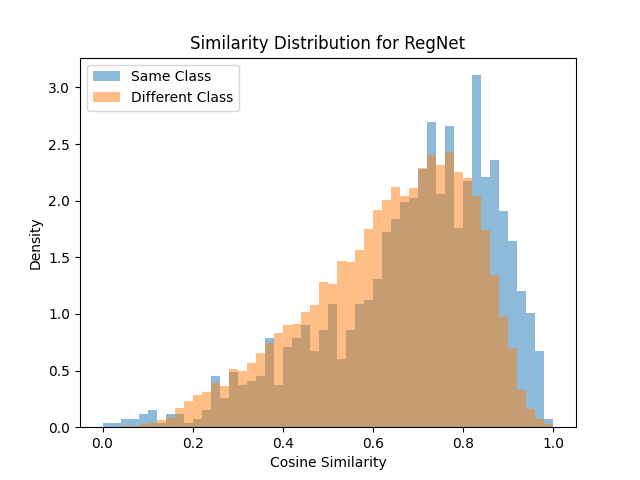 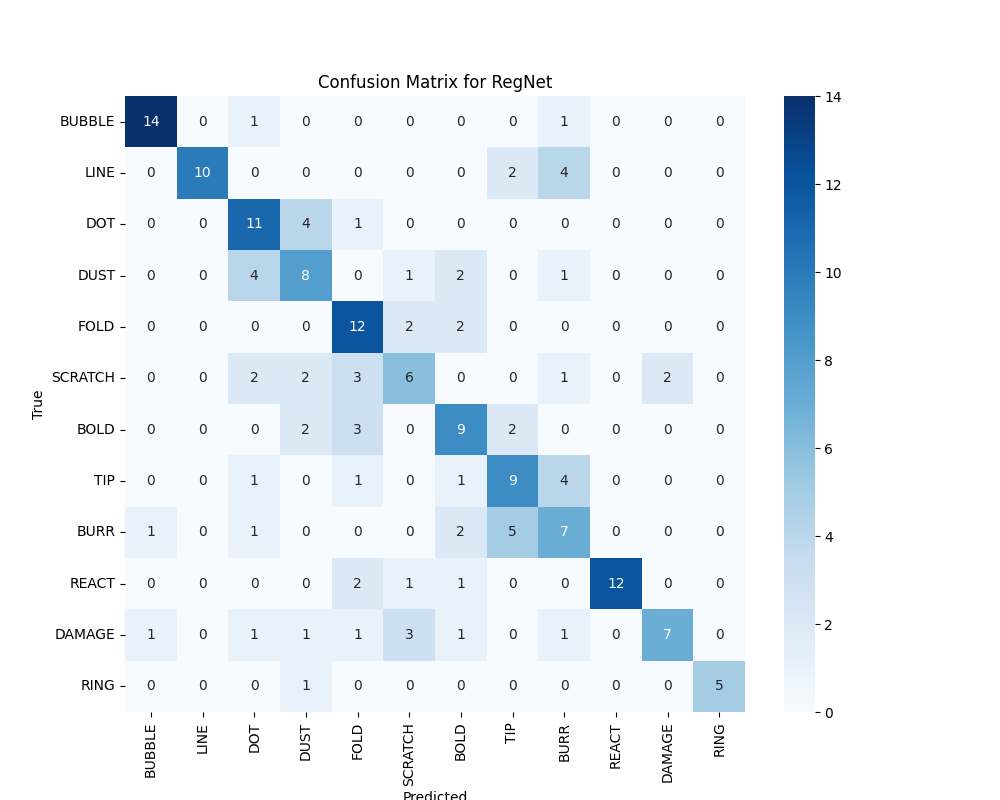

- BUBBLE, FOLD, REACT 클래스에서 높은 정확도
- LINE, DOT, SCRATCH 클래스에서 다른 클래스와 혼동되는 경우 많음

- 동일 클래스 간 유사도가 주로 0.6 ~ 0.9에서 분포(0.8에서 피크), 다른 클래스 간 유사도가 0.4 ~ 0.8 에서 분포
- 일부 클래스에서 혼동이 있을 수 있음 

### 2. DeiT
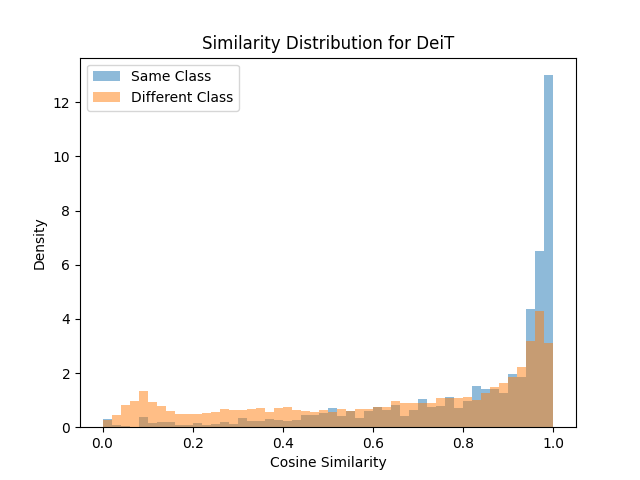 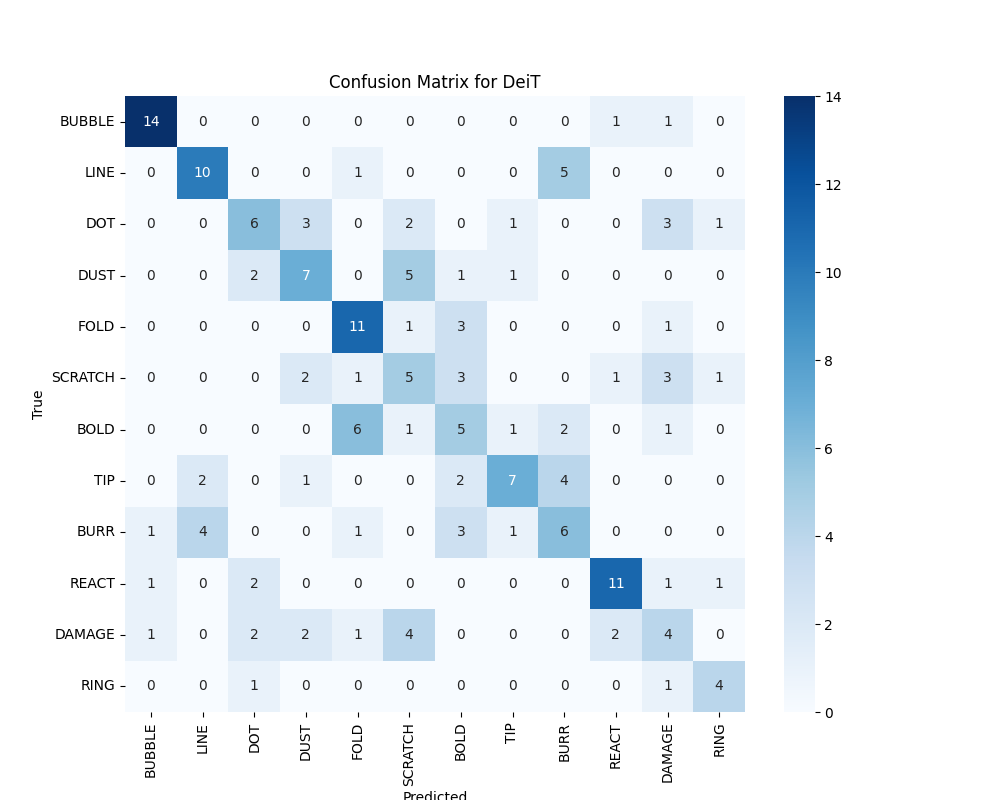

- BUBBLE, LINE, FOLD 클래스에서 높은 정확도
- DOT, SCRATCH, DAMAGE 클래스에서 다른 클래스와 혼동되는 경우가 많습니다.

- 동일 클래스 간 유사도가 주로 0.9 ~ 1.0에서 분포, 다른 클래스 간 유사도가 0.2 ~ 0.8 에서 분포
- 같은 클래스 이미지 간 매우 높은 유사도 ->  같은 클래스 이미지 잘 식별함

### 3. NFNet
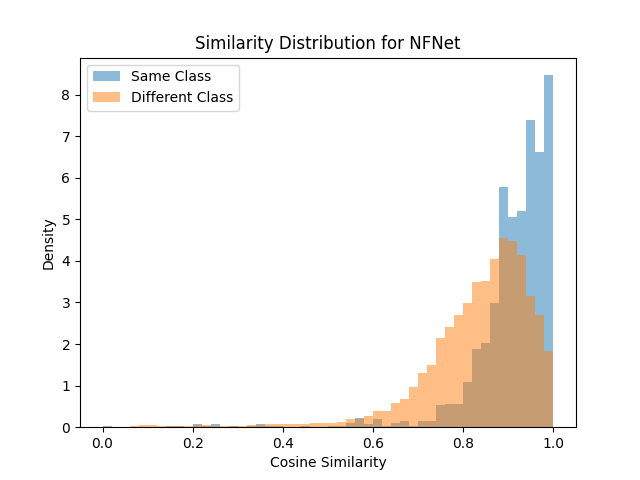 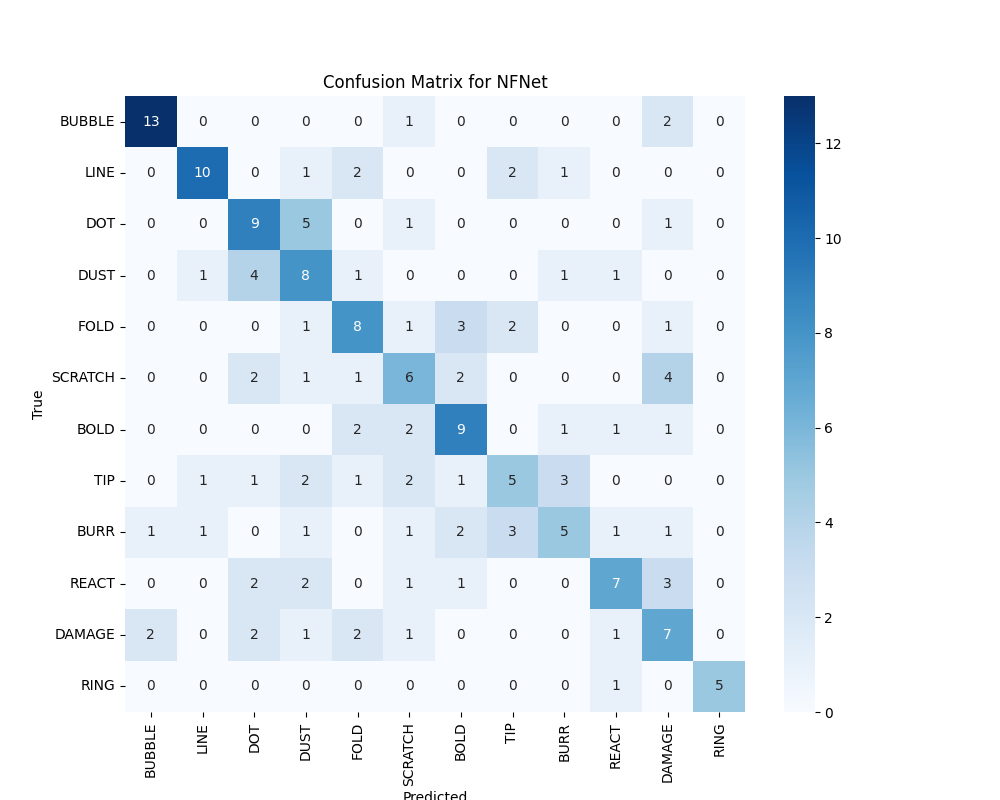

- BUBBLE, LINE, BOLD 클래스에서 비교적 높은 정확도
- DUST, FOLD, TIP 클래스에서 다른 클래스와 혼동되는 경우 많음

- 동일 클래스 간 유사도가 주로 0.8 ~ 1.0에서 분포, 다른 클래스 간 유사도가 0.6 ~ 0.8 에서 분포
- 같은 클래스 이미지 간 높은 유사도 & 다른 클래스 이미지 간 낮은 유사도 -> 같은 클래스 이미지들을 잘 구분

Model: RegNet
Processing Time per Image: 0.4320130007607596

Model: DeiT
Processing Time per Image: 0.28490108317071267

Model: NFNet
Processing Time per Image: 0.30137290666391564

In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import confusion_matrix
import time
import os
import ssl
import matplotlib.pyplot as plt
import seaborn as sns
from open_clip import create_model_and_transforms, tokenize
import timm  # Import timm for additional models
import torchvision.models as models

# SSL 인증서 설정
import certifi
os.environ['SSL_CERT_FILE'] = certifi.where()
ssl._create_default_https_context = ssl._create_unverified_context

class CoCaImg2Vec():
    def __init__(self, model_name, pretrained, cuda=False):
        self.model, _, self.transform = create_model_and_transforms(model_name, pretrained=pretrained)
        self.device = torch.device("cuda" if cuda else "cpu")
        self.model = self.model.to(self.device)
        self.model.eval()

    def get_vec(self, img):
        image = self.transform(img).unsqueeze(0).to(self.device)
        with torch.no_grad():
            embedding = self.model.encode_image(image).cpu().numpy().flatten()
        return embedding

class Img2Vec():
    def __init__(self, model_name, cuda=False):
        self.device = torch.device("cuda" if cuda else "cpu")
        if model_name in ['vit_b_16', 'swin_v2_b', 'convnext_base', 'efficientnet_v2_s', 'regnet_y_16gf']:
            self.model = getattr(models, model_name)(pretrained=True).to(self.device)
        elif model_name in ['deit_base_patch16_224', 'nfnet_f0']:
            try:
                self.model = timm.create_model(model_name, pretrained=False).to(self.device) ########################
            except RuntimeError as e:
                print(f"Skipping {model_name} due to error: {e}")
                self.model = None
        else:
            raise ValueError(f"Model {model_name} not available in torchvision.models or timm")
        if self.model:
            self.model.eval()
            self.transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])

    def get_vec(self, img):
        if self.model is None:
            return None
        image = self.transform(img).unsqueeze(0).to(self.device)
        with torch.no_grad():
            embedding = self.model(image)
        return embedding.cpu().numpy().flatten()

def load_images_from_folder(folder):
    images = []
    labels = []
    valid_image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']
    for class_folder_name in os.listdir(folder):
        class_folder_path = os.path.join(folder, class_folder_name)
        if not os.path.isdir(class_folder_path):
            continue
        for filename in os.listdir(class_folder_path):
            img_path = os.path.join(class_folder_path, filename)
            if os.path.splitext(filename)[1].lower() in valid_image_extensions:
                img = Image.open(img_path).convert('RGB')
                images.append(img)
                labels.append(class_folder_name)
    return images, labels

def pairwise_similarity_distribution(embeddings, labels):
    same_class_sims = []
    diff_class_sims = []

    num_embeddings = len(embeddings)
    for i in range(num_embeddings):
        for j in range(i + 1, num_embeddings):
            sim = cosine_similarity([embeddings[i]], [embeddings[j]])[0][0]
            if labels[i] == labels[j]:
                same_class_sims.append(sim)
            else:
                diff_class_sims.append(sim)
    
    return same_class_sims, diff_class_sims

def normalize_similarity_scores(scores):
    min_score = min(scores)
    max_score = max(scores)
    normalized_scores = [(score - min_score) / (max_score - min_score) for score in scores]
    return normalized_scores

def plot_similarity_distribution(same_class_sims, diff_class_sims, model_name, x_range):
    plt.hist(same_class_sims, bins=50, alpha=0.5, label='Same Class', density=True, range=x_range)
    plt.hist(diff_class_sims, bins=50, alpha=0.5, label='Different Class', density=True, range=x_range)
    plt.xlabel('Cosine Similarity')
    plt.ylabel('Density')
    plt.title(f'Similarity Distribution for {model_name}')
    plt.legend()
    plt.show()

def plot_confusion_matrix(true_labels, pred_labels, model_name, class_names):
    cm = confusion_matrix(true_labels, pred_labels, labels=class_names)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

def classify_images(model_dict, folder_path, cuda=False):
    images, labels = load_images_from_folder(folder_path)
    results = {}

    all_similarities = []
    for model_name, model in model_dict.items():
        print(f"Evaluating model {model_name}")
        if model_name == 'CoCa':
            img2vec = CoCaImg2Vec(model, pretrained='mscoco_finetuned_laion2b_s13b_b90k', cuda=cuda)
        else:
            img2vec = Img2Vec(model, cuda=cuda)
        if img2vec.model is None:
            continue

        start_time = time.time()
        embeddings = [img2vec.get_vec(img) for img in images]
        embeddings = [e for e in embeddings if e is not None]
        embeddings = np.array(embeddings)
        processing_time = (time.time() - start_time) / len(images)

        same_class_sims, diff_class_sims = pairwise_similarity_distribution(embeddings, labels)
        same_class_sims = normalize_similarity_scores(same_class_sims)
        diff_class_sims = normalize_similarity_scores(diff_class_sims)

        all_similarities.extend(same_class_sims + diff_class_sims)

        # 예측 레이블 생성 및 혼동 행렬 플롯
        predicted_labels = []
        for emb in embeddings:
            sims = cosine_similarity([emb], embeddings)[0]
            sims = [(s, labels[idx]) for idx, s in enumerate(sims)]
            sims = sorted(sims, key=lambda x: x[0], reverse=True)
            top_label = sims[1][1]  # 가장 유사한 (자기 자신을 제외한) 이미지의 레이블 선택
            predicted_labels.append(top_label)
        
        class_names = list(set(labels))
        plot_confusion_matrix(labels, predicted_labels, model_name, class_names)

        results[model_name] = {
            'same_class_sims': same_class_sims,
            'diff_class_sims': diff_class_sims,
            'processing_time': processing_time
        }

    global_xlim = (0, 1)
    for model_name, result in results.items():
        plot_similarity_distribution(result['same_class_sims'], result['diff_class_sims'], model_name, global_xlim)

    return results

if __name__ == "__main__":
    folder_path = './data-gatter/train_L'
    from torchvision import models as torchvision_models

    model_dict = {
        #'OmniVec (ViT)': 'vit_b_16',
        #'CoCa': 'coca_ViT-B-32',
        #'Swin Transformer V2': 'swin_v2_b',
        #'ConvNeXt': 'convnext_base',
        #'EfficientNetV2': 'efficientnet_v2_s',
        'RegNet': 'regnet_y_16gf',
        'DeiT': 'deit_base_patch16_224',
        'NFNet': 'nfnet_f0'
    }

    cuda = torch.cuda.is_available()

    results = classify_images(model_dict, folder_path, cuda)
    for model_name, result in results.items():
        print(f"\nModel: {model_name}")
        print(f"Processing Time per Image: {result['processing_time']}")


# **최종 결론**
## 전반적으로 모델들이 높은 성능을 보이지만, 유사도 분포와 혼동 행렬을 종합적으로 평가했을 때, **ConvNeXt**가 가장 우수한 성능을 보입니다. 
## ConvNeXt는 유사도 분포에서 같은 클래스 이미지를 잘 구분, 혼동 행렬에서도 상대적으로 높은 정확도. 
